# **Ensembles**

### ***Importeren***

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

In [95]:
df=pd.DataFrame()

In [96]:
import pandas as pd
data = pd.read_csv('data/train.csv')

In [97]:
data['stroke'].value_counts()

stroke
0    33033
1      517
Name: count, dtype: int64

### ***Data splitsen***

In [98]:
X = data.drop("stroke", axis=1)
y = data["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### ***Modellen trainen***

#### *RandomForest*
Random forest zijn allemaal decisiontrees bij elkaar. Deze decisiontrees maken gebruik van **bagging (bootstrap aggregation)** wat inhoud dat meerdere modellen onafhankelijk van elkaar getrained worden. Dit gebeurt wel op stukjes van de data, ook wel subsets genoemd. Bij elke splitsing worden er ook willekeurig features gekozen. Dit onafhankelijk trainen van elkaar geeft aan dat deze ensemble **parallel** is. Dit heeft als voordeel dat de trainingstijd een stuk lager is dan modellen die sequentieel trainen. Later in dit notebook komt sequentieel trainen nog aan bod.

Bij het trainen van modellen als random forest moet je vooraf bepaalde instellingen meegeven, dit zijn de hyperparameters. Deze moeten vooraf worden ingesteld, aangezien deze niet uit de data zelf worden geleerd. Deze parameters zorgen voor de manier hoe het model leert. Het proces van de beste waarden uitkiezen voor de hyperparameter heet hyperparameter tuning.

Wij hebben de **hyperparameter tuning** gedaan met GridSearchCV. Deze methode werkt eigenlijk heel simpel, aangezien dit alle combinaties van meegegeven waarden van de hyperparameters gaat proberen. Hierbij kiest best_estimator_ het best presterende model en best_params_ de bijbehorende hyperparameters met hun waarden.

In [117]:
# Aanmaken van RandomForestClassifier, met class_weight='balanced' zorg je ervoor dat de fouten in de minderheidsklasse zwaarder meetellen
rf = RandomForestClassifier(class_weight='balanced')

# Hier wordt hyperparameter tuning toegepast
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 12],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

# Instellen en trainen van de gridsearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='f1_macro', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

# Bepalen van beste model en bijbehorende parameters met hun waarden
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Printen van beste parameters met hun waarden
print("Beste hyperparameters:", best_params)

KeyboardInterrupt: 

In [109]:
# Hier wordt het model getraind met de beste parameters en wordt een f1_score gemaakt. 
# Wij maken gebruik van average='macro', omdat hier de meerderheidsklasse niet perse een grotere invloed heeft op het resultaat. 
best_model_rf = RandomForestClassifier(class_weight='balanced', max_depth=5, max_features='sqrt', min_samples_leaf=4, n_estimators=100, min_samples_split=10)
best_model_rf.fit(X_train, y_train)
y_pred = best_model_rf.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.46830257147215376

## **Confusion Matrix**
Om meer inzicht te krijgen in de prestaties van het model hebben wij gebruik gemaakt van een confusion matrix. Je kunt de confusion matrix van je traindata vergelijken met die van je testdata, als deze allebei dicht bij elkaar zitten met bijvoorbeeld het aantal false positives betekent dit dat je model goed gefit is. Het is dan alleen nog de vraag of je blij bent met deze resultaten. Het is van te voren belangrijk om een beslissing te maken over wat je wilt optimaliseren.

Als je het aantal False Negatives (gemiste strokes) wilt minimaliseren moet je ervoor zorgen dat je model een hoge recall heeft.

Wil je het aantal False Positives (fout voorspelde strokes) wilt minimaliseren kies je voor het optimaliseren van de precision.

Confusion Matrix:
[[22382   745]
 [   17   341]]


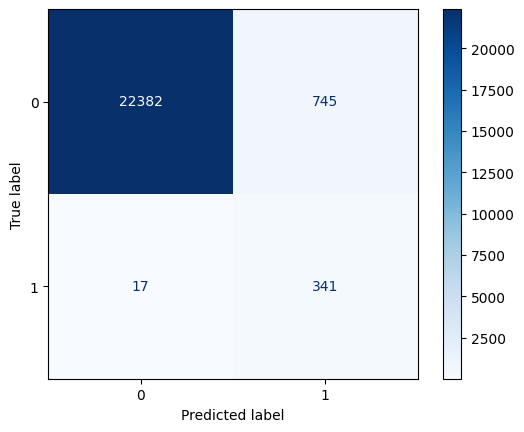

In [100]:
# Hier wordt een confusion matrix van de prestaties van het model op de trainset
y_pred = best_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[9556  350]
 [ 131   28]]


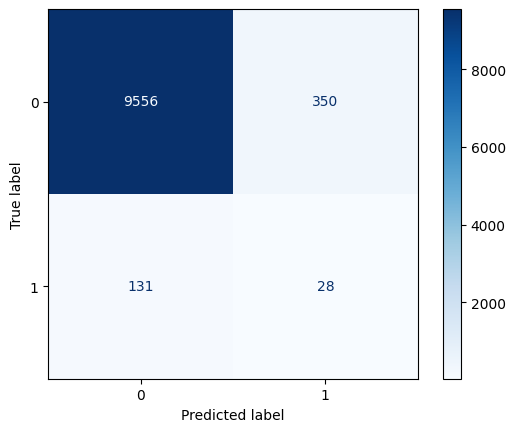

In [101]:
# Hier wordt een confusion matrix van de prestaties van het model op de testset
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### *GradientBoosting*
Bij gradient boosting wordt er ook gebruik gemaakt van het trainen van bomen alleen wordt deze d.m.v. boosting sequentieel getrainend. Boosting houdt in dat elke boom getrainend wordt op basis van de fouten die de vorige boom heeft gemaakt. Doordat boosting op deze manier werkt moet het model dus sequentieel trainen, omdat deze eerst moet wachten op de resultaten voor de vorige boom. Aangezien dit model dus niet tegelijk trained maar achter elkaar zorgt dit dus voor een tragere trainingstijd.

In [54]:
# Aanmaken van GradientBoostingClassifier
gbdt = GradientBoostingClassifier()


param_grid_gbdt = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 3]
}

grid_search_gbdt = GridSearchCV(estimator=gbdt, param_grid=param_grid_gbdt, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_gbdt.fit(X_train, y_train)

best_params_gbdt = grid_search_gbdt.best_params_
best_gbdt_model = grid_search_gbdt.best_estimator_
print("Beste hyperparameters voor GBDT:", best_params_gbdt)

Beste hyperparameters voor GBDT: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [91]:
best_model_gbdt = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_split=10, min_samples_leaf=2, n_estimators=200)
best_model_gbdt.fit(X_train, y_train)
y_pred = best_model_gbdt.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.5080891560230403

Confusion Matrix:
[[23011   116]
 [  123   235]]


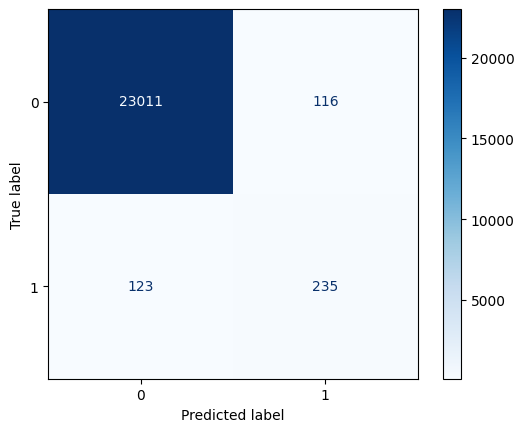

In [73]:
# Hier wordt een confusion matrix van de prestaties van het model op de trainset
y_pred = best_gbdt_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

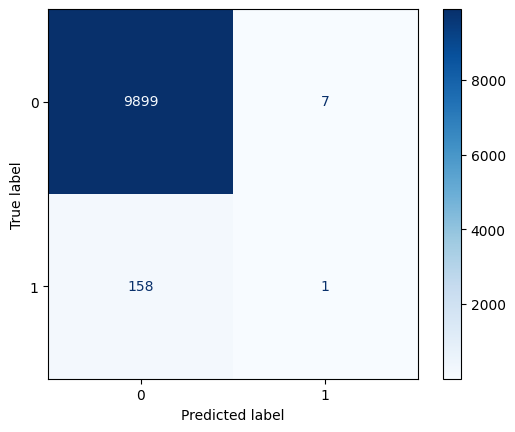

In [106]:
# Hier wordt een confusion matrix van de prestaties van het model op de testset
y_pred = best_gbdt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### *XGBoosting*
XGBoosting, ook wel extreme gradient boosting, is simpelweg de geavanceerde versie van gradient boosting. Het heeft verschillende optimalisaties die ervoor zorgen dat het model sneller en efficienter werkt. Het model bevat regularisatie wat zorgt voor vermindering in overfitting. Ook net als bij gradient boosting worden de bomen in dit model sequentieel getrained, omdat de bomen de fouten van de vorige boom. Het enige verschil tussen XGBoosting en GradientBoosting zijn dus de extra hyperparameters die ervoor zorgen dat het sneller werkt en overfitting vermindert.

In [59]:
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

best_xgb_params = grid_search_xgb.best_params_
print("Beste hyperparameters:", best_xgb_params)

best_xgb_model = grid_search_xgb.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Beste hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.9842
ROC AUC Score: 0.8564


In [93]:
best_model_xgb = XGBClassifier(learning_rate=0.01, max_depth=3, colsample_bytree=0.8, subsample=0.8, n_estimators=200)
best_model_xgb.fit(X_train, y_train)
y_pred = best_model_xgb.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_macro

0.4960192278804266

Confusion Matrix:
[[23127     0]
 [  358     0]]


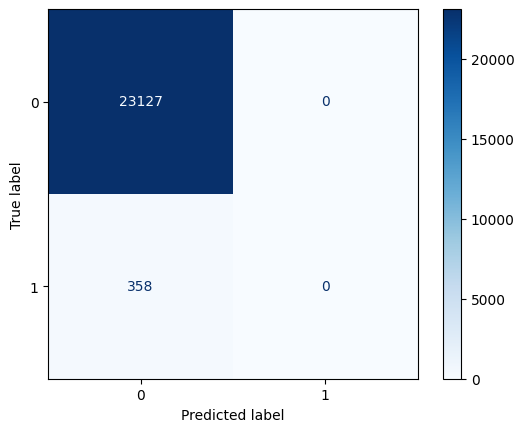

In [74]:
# Hier wordt een confusion matrix van de prestaties van het model op de trainset
y_pred = best_xgb_model.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

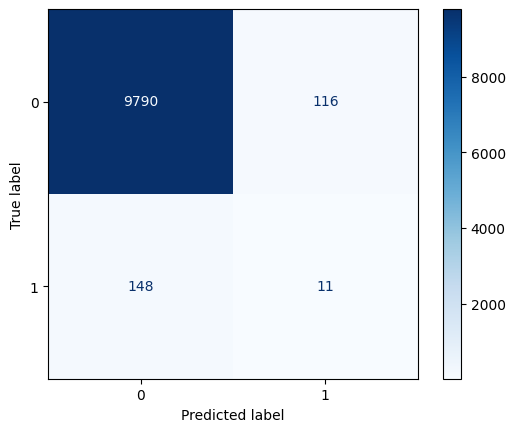

In [111]:
# Hier wordt een confusion matrix van de prestaties van het model op de testset
y_pred = best_xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **Zelfgemaakte Ensemble**
Een **ensemble** is machine learning techniek waar de voorspellingen van meerdere modellen worden gecombineerd om zo de algehele prestaties te verbeteren. Dit wordt gebruikt, omdat dit meestal betere prestaties oplevert dan een enkel model doordat ze de fouten beter op kunnen vangen en compenseren. Deze fouten worden namelijk door het sequenteel trainen gecompenseerd.

Een ensemble kan werken met bagging of boosting, maar ook met een **VotingClassifier**. Hierbij gebruik je ook meerdere modellen, maar het verschil hier is dat je verschillende typen modellen gebruikt. Als je verschillende typen modellen combineert, resulteert dit in een robuust(er) model.

Wij hebben hier voor **soft voting** gekozen, omdat ze hier niet alleen kijken naar welke komt het meest voor maar ook naar de waarschijnlijkheid dat de waarde goed is voorspeld. Dit betekent dat elk model voor elk punt voorspelt hoe groot de kans is dat het punt wel of geen stroke is. Modellen kunnen verschillende mate van zekerheid hebben in hun voorspellingen en deze manier van voting (soft voting) zorgt ervoor dat de voorspellingen met een hoge waarschijnlijkheid voor een bepaalde voorspelling, ook meer invloed heeft.
Dit leidt vaak tot betere prestaties, vooral bij ongebalanceerde datasets waar wij in dit geval mee te maken hebben. 

Ik heb voor de modellen **RandomForestClassifier**, **GradientBoostingClassifier** en **XGBoosting**, omdat deze verschillende sterke punten hebben en daarom samen een robuust model kunnen vormen. De RandomForestClassifier zorgt voor een snellere training en vermindert de overfitting, omdat dit model gebruik maakt van bagging. GradientBoostingClassifier verbetert de prestaties, omdat het sequenteel wordt getraind en dus de fout van de vorige boom corrigeert wat leidt tot nauwkeurige voorspellingen. XGBoosting combineert deze twee modellen eigenlijk, omdat het met regularisatie de overfitting vermindert en met de optimalisaties versnelt het de trainingstijd.

In [113]:
best_model_rf = RandomForestClassifier(
    n_estimators=100, max_depth=12, min_samples_leaf=8, min_samples_split=2, max_features='sqrt', class_weight='balanced'
)
best_model_rf.fit(X_train, y_train)

best_gbdt_model = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200
)
best_gbdt_model.fit(X_train, y_train)

best_xgb_model = XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=200, scale_pos_weight=9, eval_metric='logloss'
)
best_xgb_model.fit(X_train, y_train)



ensemble = VotingClassifier(estimators=[
    ('rf', best_model_rf),
    ('gbdt', best_gbdt_model),
    ('xgb', best_xgb_model)
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

f1_macro = f1_score(y_test, y_pred_ensemble, average='macro')
roc_auc = roc_auc_score(y_test, ensemble.predict_proba(X_test)[:, 1])

print(f"F1-score (macro): {f1_macro}")
print(f"ROC AUC Score: {roc_auc}")


F1-score (macro): 0.507512330101269
ROC AUC Score: 0.8429545907632372


### ***Vergelijken van modellen***

In [114]:
y_pred_rf = best_model.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

y_pred_gbdt = best_gbdt_model.predict(X_test)
print("Gradient Boosted Decision Trees:")
print(classification_report(y_test, y_pred_gbdt))

y_pred_xgb = best_xgb_model.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

print("DIY Ensemble:")
print(classification_report(y_test, y_pred))

Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      9906
           1       0.06      0.69      0.10       159

    accuracy                           0.81     10065
   macro avg       0.53      0.75      0.50     10065
weighted avg       0.98      0.81      0.88     10065

Gradient Boosted Decision Trees:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9906
           1       0.33      0.01      0.02       159

    accuracy                           0.98     10065
   macro avg       0.66      0.51      0.51     10065
weighted avg       0.97      0.98      0.98     10065

XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9906
           1       0.09      0.07      0.08       159

    accuracy                           0.97     10065
   macro avg       0.54      0.53      0.53     10065
weighted avg     